Optical alignment has improved. Working with 0.75 mW optical power and getting ~1e6 counts per second


Need to check the raw data traces after data acquisition. 
While using the pulseblaster, the AOM and RF pulse response times could be significantly different (?). Why would they be? Cables are the same


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM, PulseBlasterArb
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [5]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [135]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)
    
def plot_frequency(scan_data,  experiment, freq = 2870e6):
    frequencies = np.array([x[0] for x  in scan_data ])
    #res_index = np.where(np.isclose(frequencies,freq))
    idx = (np.abs(frequencies - freq)).argmin()
    scan = scan_data[idx]
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])

In [6]:
logging.basicConfig(level=logging.WARNING)
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)
datasources.daqsamplers.logger.setLevel(logging.INFO)

In [7]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [83]:
#first, isolate an NV orientation 
cwodmr_pulser = PulseBlasterCWODMR(pb_board_number=0, clock_period = 100e-9)

In [84]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [85]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-20)

In [86]:
cwodmr_pulser.rf_pulse_duration = 5e-6

In [87]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -20,
 'pulser': {'rf_pulse_duration': 5e-06, 'clock_period': 1e-07}}

In [88]:
cwodmr_exp.freq_low = 2700e6
cwodmr_exp.freq_high = 3000e6
cwodmr_exp.freq_step = 2e6
cwodmr_exp.rf_power = -10

In [90]:
scan_data = {'data':cwodmr_exp.run(N_cycles=40000), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2714000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2716000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2718000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2720000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2722000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2724000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2726000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2728000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27300000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2962000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2964000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2966000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2968000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2970000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2972000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2974000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2976000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2978000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2980000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2982000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2984000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2986000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2988000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2990000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29920000

<IPython.core.display.Javascript object>


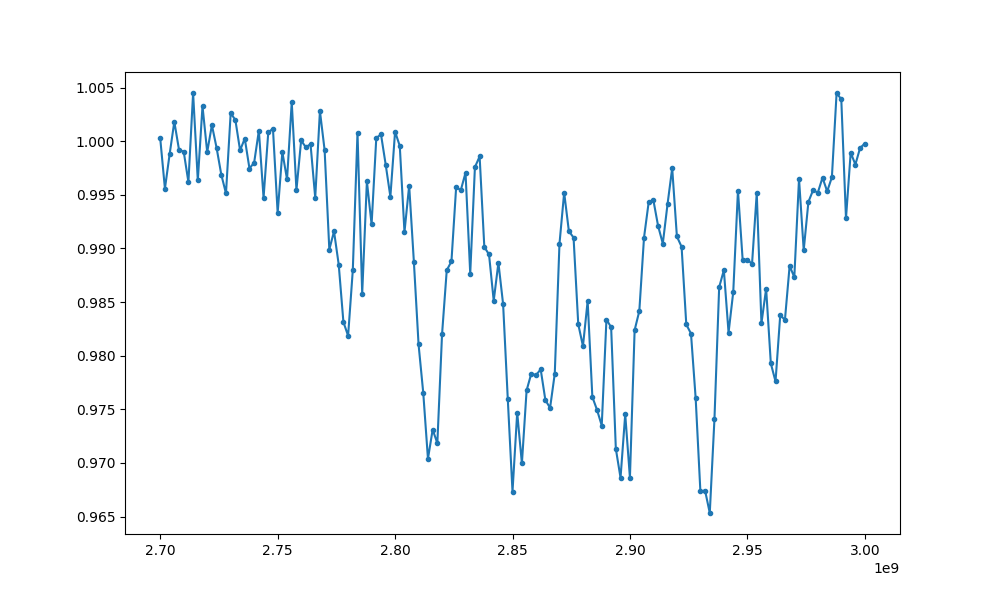

In [91]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [92]:
cwodmr_exp.freq_low = 2920e6
cwodmr_exp.freq_high = 2950e6
cwodmr_exp.freq_step = 2e6
cwodmr_exp.rf_power = -10
raw_trace_data = cwodmr_exp.run(N_cycles=200000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2920000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2922000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2924000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2930000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2932000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2934000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2936000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2938000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2940000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2942000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2944000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2946000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2948000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29500000

<IPython.core.display.Javascript object>


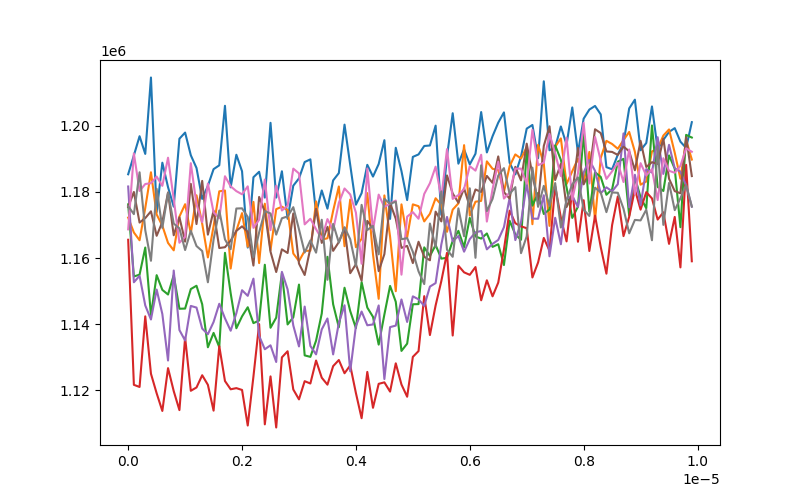

In [93]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in raw_trace_data[::2]:
    
    plot_trace(scan[1], cwodmr_exp.N_cycles, clock_rate = 1./cwodmr_exp.pulser.clock_period, label = scan[0])

<IPython.core.display.Javascript object>


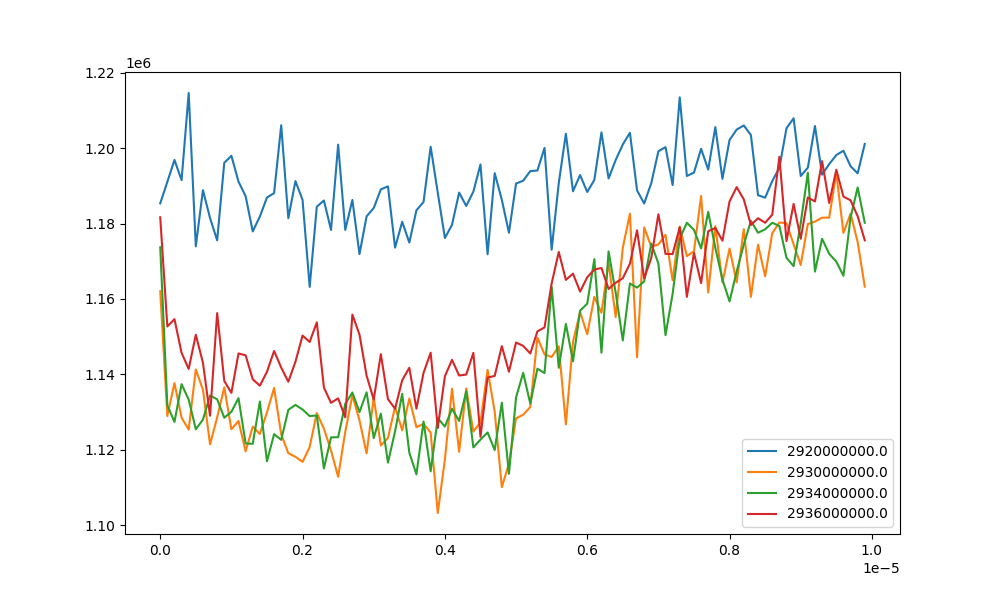

In [137]:
fig, ax = plt.subplots(figsize=(10,6))

# off resonance
plot_frequency(raw_trace_data, cwodmr_exp, 2918e6)

# on resonance
plot_frequency(raw_trace_data, cwodmr_exp, 2930e6)
plot_frequency(raw_trace_data, cwodmr_exp, 2934e6)
plot_frequency(raw_trace_data, cwodmr_exp, 2936e6)

plt.legend()

In [136]:
def contrast_calculator(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    rf_on = trace[len(trace)//4:len(trace)//2]
    rf_off = trace[3*len(trace)//4:]
    return np.sum(rf_on)/np.sum(rf_off)


In [17]:
#narrowing on far right +1 peak

In [138]:
cwodmr_exp.freq_low = 2920e6
cwodmr_exp.freq_high = 2950e6
cwodmr_exp.freq_step = 1e6
cwodmr_exp.rf_power = -15

In [139]:
scan_data_pos2 = {'data':cwodmr_exp.run(N_cycles=40000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2920000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2921000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2922000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2923000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2924000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2929000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2930000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2931000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2932000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2933000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2934000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29350000

<IPython.core.display.Javascript object>


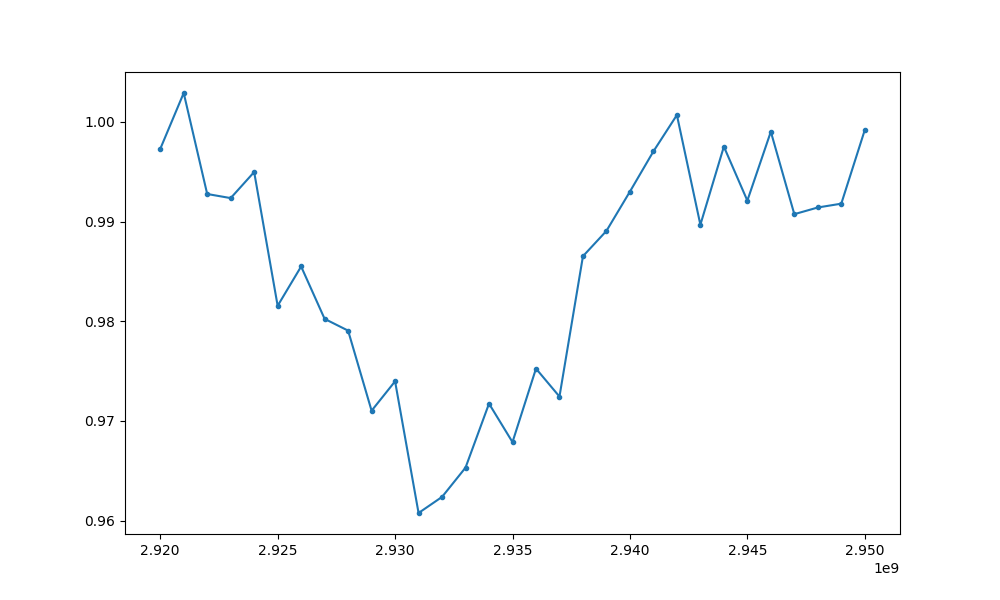

In [140]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_pos2['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [141]:
#decreasing power
cwodmr_exp.freq_step = 1e6
cwodmr_exp.rf_power = -20

In [142]:
scan_data_single_orientation = {'data':cwodmr_exp.run(N_cycles=80000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2920000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2921000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2922000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2923000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2924000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2929000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2930000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2931000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2932000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2933000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2934000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29350000

<IPython.core.display.Javascript object>


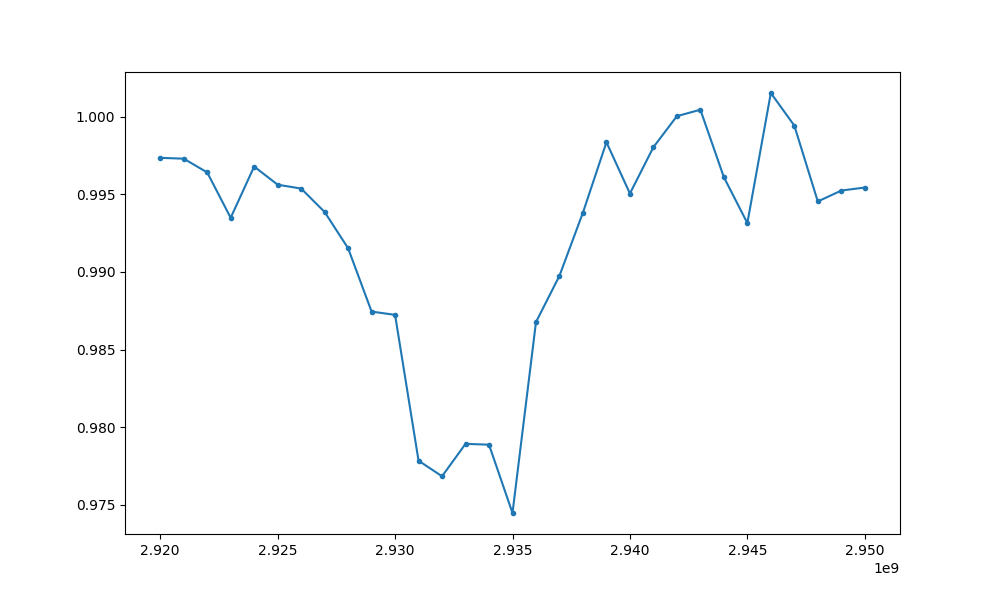

In [143]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [144]:
#decreasing power
cwodmr_exp.freq_step = .5e6
cwodmr_exp.rf_power = -25

In [145]:
scan_data_single_orientation_m25 = {'data':cwodmr_exp.run(N_cycles=80000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2920000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2920500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2921000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2921500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2922000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2922500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2923000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2923500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2924000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2924500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29275000

<IPython.core.display.Javascript object>


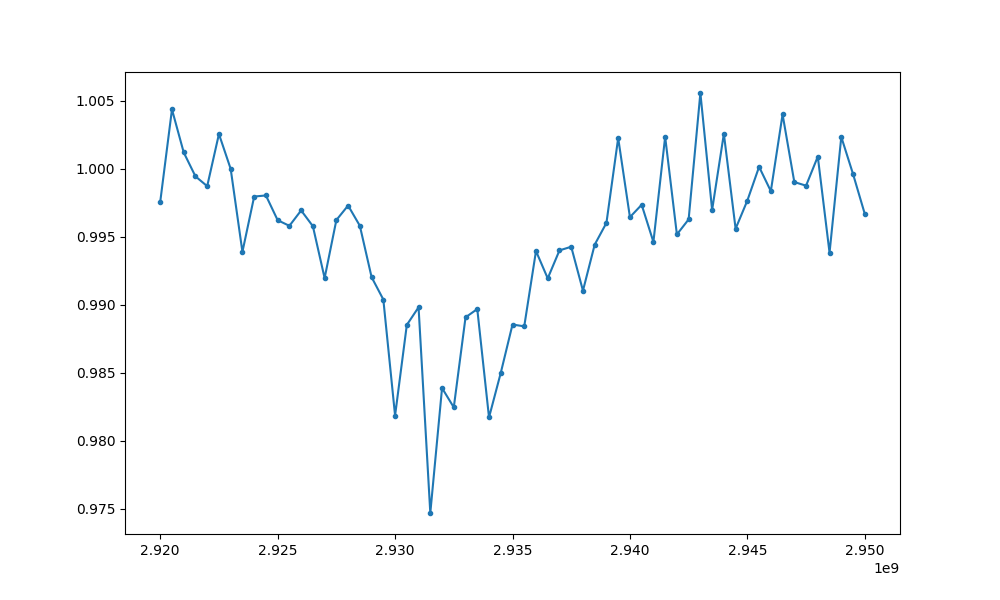

In [146]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m25['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [147]:
#narrowing
cwodmr_exp.freq_low = 2925e6
cwodmr_exp.freq_high = 2940e6
cwodmr_exp.freq_step = .25e6
cwodmr_exp.rf_power = -30

In [149]:
scan_data_single_orientation_m30 = {'data':cwodmr_exp.run(N_cycles=200000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2925000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2925750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2926750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2927750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2928500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29287500

<IPython.core.display.Javascript object>


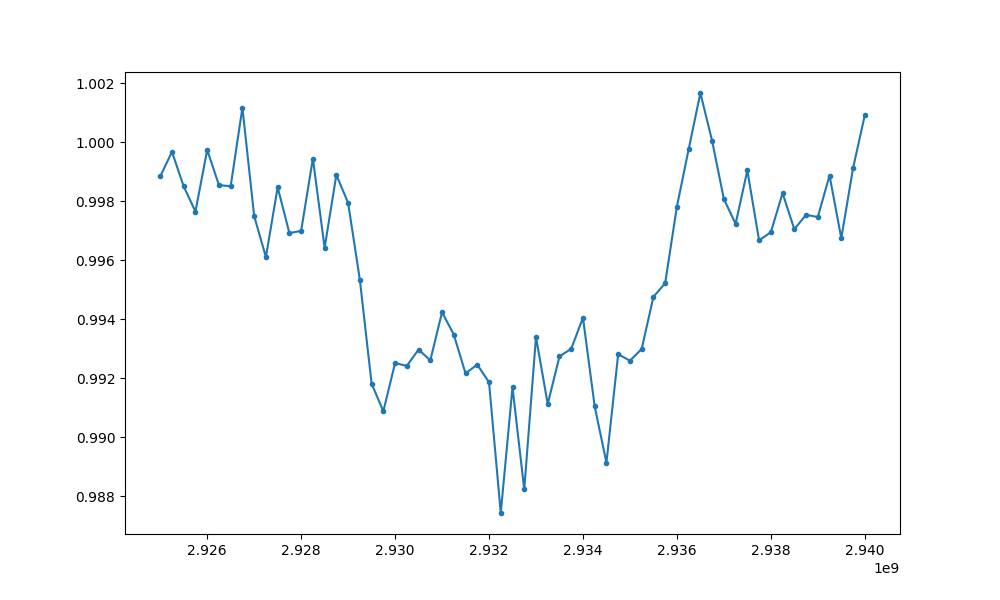

In [150]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m30['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [43]:
#Pulsed ODMR - let's guess a pi pulse time of 1 microsecond, as we did previously

In [166]:
podmr_pulser = PulseBlasterPulsedODMR(pb_board_number=0, clock_period = 100e-9,
                                      aom_width=3e-6,
                                      rf_pulse_duration=1e-6, 
                                      rf_response_time=3e-7,
                                     full_cycle_width=10e-6)
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

podmr_exp = qt3utils.experiments.podmr.PulsedODMR(podmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-25, 
                                                  freq_low=cwodmr_exp.freq_low,
                                                  freq_high=cwodmr_exp.freq_high,
                                                  freq_step=.5e6)

In [60]:
qt3utils.experiments.podmr.logger.setLevel(logging.INFO)

In [196]:
podmr_exp.experimental_conditions()

{'freq_low': 2925000000.0,
 'freq_high': 2940000000.0,
 'freq_step': 500000.0,
 'rf_power': -25,
 'pulser': {'rf_pulse_duration': 1e-06,
  'aom_width': 3e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 1e-05,
  'rf_pulse_justify': 'center',
  'clock_period': 1e-07}}

In [167]:
podmr_raw_scan = podmr_exp.run(N_cycles=200000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.podmr:RF frequency: 2.9250000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9255 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.926 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9265000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.927 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9275 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9280000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9285 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9290000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9295 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.93 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9305000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.931 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9315 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9320000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9325 GHz
INFO:qt3utils.experim

In [168]:
podmr_raw_scan

array([[2925000000.0,
        array([   64.,    51.,    68.,    69.,    41.,  8102., 25911., 25756.,
               25713., 25702., 25870., 25462., 25786., 25933., 25796., 25860.,
               25816., 25730., 25728., 25716., 25828., 25779., 25810., 25831.,
               25676., 26214., 26020., 25627., 25761., 25211., 25901., 25667.,
               25715., 25772., 25617., 17681.,   349.,   110.,    96.,    67.,
                  65.,    75.,    79.,    78.,    74.,    63.,    63.,    60.,
                  72.,    66.,    45.,    53.,    59.,    58.,    61.,  7839.,
               26033., 25718., 25754., 25764., 25675., 25940., 25832., 25648.,
               25615., 25698., 25658., 25707., 25722., 25673., 25635., 25678.,
               25803., 26109., 25999., 25885., 25909., 25718., 25528., 25788.,
               26221., 25789., 25868., 25849., 25812., 17620.,   353.,   111.,
                 108.,    82.,    80.,    72.,    73.,    83.,    69.,    81.,
                  76.,    64.,

<IPython.core.display.Javascript object>


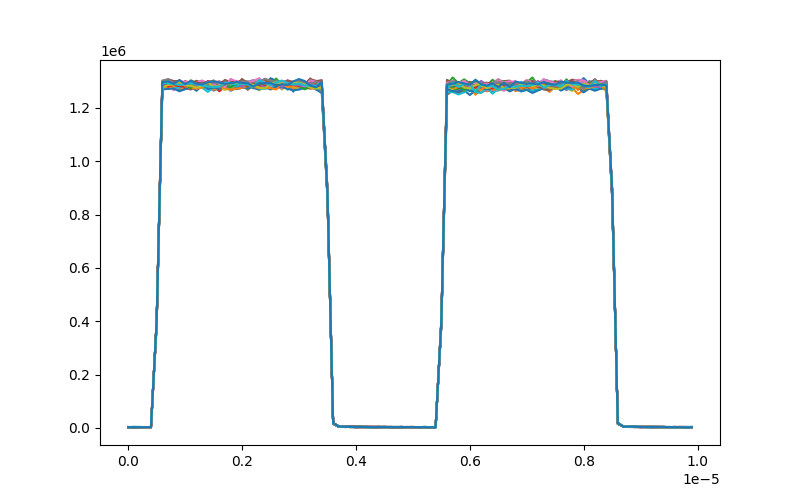

In [176]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in podmr_raw_scan:
    
    plot_trace(scan[1], podmr_exp.N_cycles, clock_rate = 1./podmr_exp.pulser.clock_period, label = scan[0])

In [188]:
def podmr_contrast(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    trace = trace/experiment.N_cycles / experiment.pulser.clock_period
    trace[trace < 1e4] = 0
    background = trace[:len(trace)//2]
    signal = trace[len(trace)//2:]
    return np.sum(signal)/np.sum(background)

In [192]:
#default 
podmr_scan = podmr_exp.run(N_cycles=600000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.podmr:RF frequency: 2.9250000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9255 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.926 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9265000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.927 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9275 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9280000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9285 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9290000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9295 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.93 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9305000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.931 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9315 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9320000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9325 GHz
INFO:qt3utils.experim

In [193]:
podmr_scan

array([[2.92500000e+09, 9.99149535e-01],
       [2.92550000e+09, 1.00033830e+00],
       [2.92600000e+09, 9.98530553e-01],
       [2.92650000e+09, 9.99279021e-01],
       [2.92700000e+09, 9.99750344e-01],
       [2.92750000e+09, 1.00043093e+00],
       [2.92800000e+09, 9.99806883e-01],
       [2.92850000e+09, 9.97408142e-01],
       [2.92900000e+09, 9.98668074e-01],
       [2.92950000e+09, 9.99784209e-01],
       [2.93000000e+09, 9.93625606e-01],
       [2.93050000e+09, 9.92345128e-01],
       [2.93100000e+09, 9.96238100e-01],
       [2.93150000e+09, 9.96061305e-01],
       [2.93200000e+09, 9.93770667e-01],
       [2.93250000e+09, 9.92683361e-01],
       [2.93300000e+09, 9.96544121e-01],
       [2.93350000e+09, 9.96879048e-01],
       [2.93400000e+09, 9.96031008e-01],
       [2.93450000e+09, 9.93274736e-01],
       [2.93500000e+09, 9.94729930e-01],
       [2.93550000e+09, 9.97407332e-01],
       [2.93600000e+09, 9.98409879e-01],
       [2.93650000e+09, 9.96910682e-01],
       [2.937000

<IPython.core.display.Javascript object>


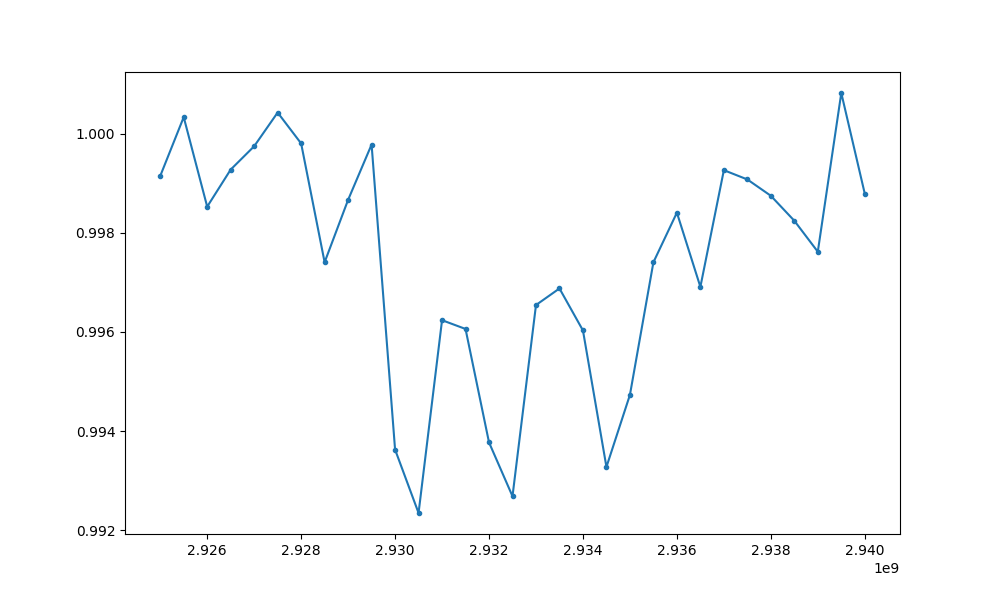

In [194]:
plt.figure(figsize=(10,6))
scan = np.array(podmr_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [198]:
resonance_freq = 2932.5e6

In [195]:
qt3utils.experiments.rabi.Rabi?

In [204]:
qt3utils.experiments.rabi.logger.setLevel(logging.INFO)


In [201]:
podmr_pulser = PulseBlasterPulsedODMR(pb_board_number=0, clock_period = 100e-9,
                                      aom_width=3e-6,
                                      rf_pulse_duration=1e-6, 
                                      rf_response_time=3e-7,
                                     full_cycle_width=30e-6)

rabi_exp = qt3utils.experiments.rabi.Rabi(podmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-25,rf_frequency=resonance_freq)

In [203]:
rabi_exp.experimental_conditions()

{'rf_pulse_duration_low': 1e-07,
 'rf_pulse_duration_high': 1e-05,
 'rf_pulse_duration_step': 5e-08,
 'rf_power': -25,
 'rf_frequency': 2932500000.0,
 'pulser': {'rf_pulse_duration': 2.65e-06,
  'aom_width': 3e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 3e-05,
  'rf_pulse_justify': 'center',
  'clock_period': 1e-07}}

In [205]:
rabi_raw_scan = rabi_exp.run(N_cycles=2000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.rabi:RF Width: 1e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9.5e-07 

INFO:qt3utils.experiments.rabi:RF Width: 7.3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.35e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.45e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.55e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.65e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.7e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.75e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.85e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.9e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.95e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.05e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.1e-06 seconds
INFO:qt3utils.experiments

<IPython.core.display.Javascript object>


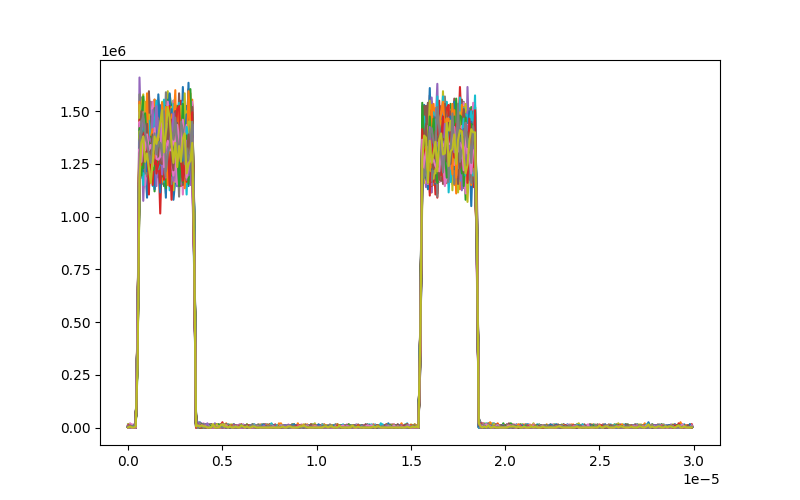

In [206]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in rabi_raw_scan:
    
    plot_trace(scan[1], rabi_exp.N_cycles, clock_rate = 1./rabi_exp.pulser.clock_period, label = scan[0])

In [215]:
rabi_exp.rf_pulse_duration_high = 5e-6
rabi_exp.rf_pulse_duration_step = 100e-9

In [216]:
rabi_scan = rabi_exp.run(N_cycles=200000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.rabi:RF Width: 1e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.7e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 se

<IPython.core.display.Javascript object>


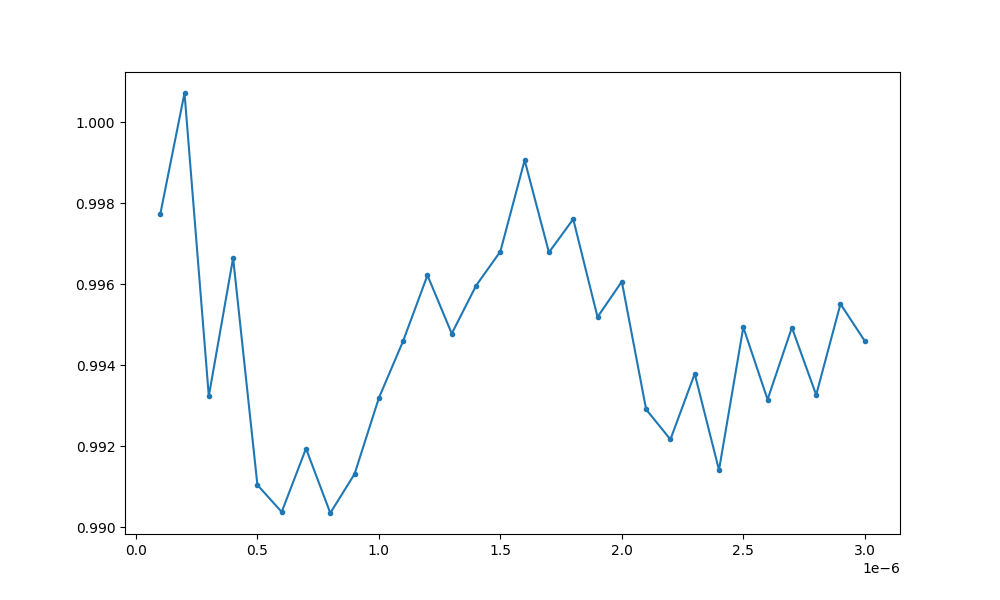

In [217]:
plt.figure(figsize=(10,6))
scan = np.array(rabi_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [224]:
podmr_exp.pulser.rf_pulse_duration = 0.75e-6
podmr_exp.freq_step = 0.1e6
podmr_exp.freq_low = 2928e6
podmr_exp.freq_high = 2938e6


In [227]:
podmr_scan = podmr_exp.run(N_cycles=500000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.podmr:RF frequency: 2.9280000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9281 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9282000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9283 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9284000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9285 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9286000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9287 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9288000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9289 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9290000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9291 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9292000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9293 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9294000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9

<IPython.core.display.Javascript object>


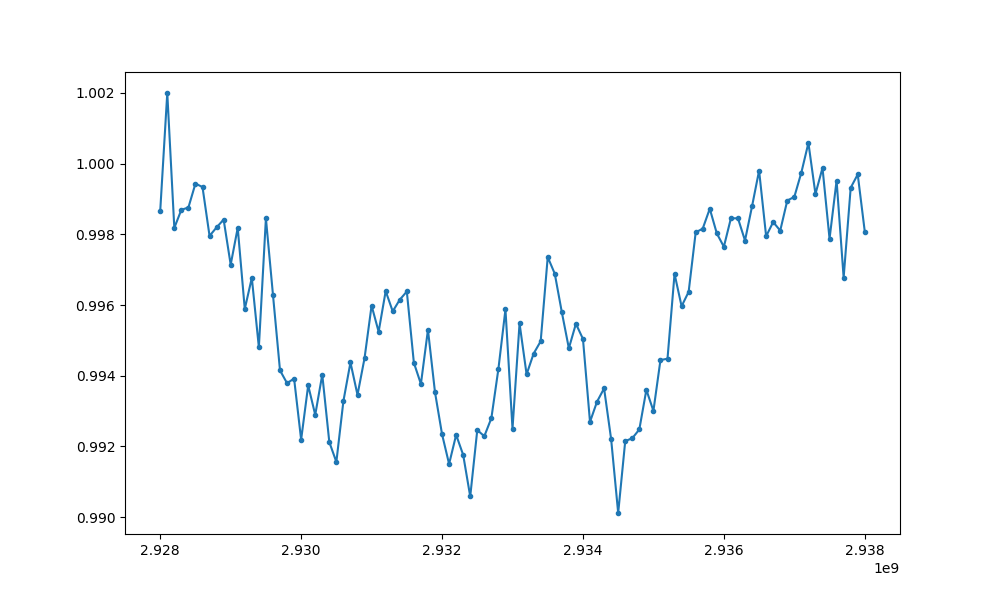

In [228]:
plt.figure(figsize=(10,6))
scan = np.array(podmr_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')